Initialing SparkSession and Loading Flight Data

In [21]:
# mounting the google drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#Install the Pyspark
!pip install pyspark

# importing the required classes
import pyspark
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import SQLTransformer

from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer

import matplotlib.pyplot as plt
import numpy as np
import time

# creating a spark session
spark = SparkSession.builder.master('local[*]').appName('Flight Delay Prediction').getOrCreate()

# Load the pre-processed data from drive 
flights_df = spark.read.csv('/content/drive/MyDrive/532/ProcessedFlights', sep=',', header=True, inferSchema=True, nullValue='NA')

# printing the columns and their types
flights_df.show(5)
print(flights_df.dtypes)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+-------------------+---------------+----------------+-------------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|carrier_transformed|org_transformed|dest_transformed|tailnum_transformed|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+-------------------+---------------+---------------

Pre-processing the flight data 

In [23]:
# Create an assembler object to consolidate the features
relevantCols = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 'carrier_transformed', 'org_transformed', 'dest_transformed', 'tailnum_transformed']
assembler = VectorAssembler(inputCols=relevantCols, outputCol='features')
flights_consolidate = assembler.transform(flights_df)

# Selecting the features and delay values using SQLTransformer
transformer = SQLTransformer(statement="SELECT ArrDelay, features FROM __THIS__")
flights_data = transformer.transform(flights_consolidate)

# Indexing categorical feature using VectorIndexer
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32).fit(flights_data)

# Split the data for training and test
flights_train2, flights_test2 = flights_data.randomSplit([0.8, 0.2])

In [24]:
# Start Execution time
time_init = time.time()

#Creating Random Forest Regressor model 
rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol="ArrDelay")

#Create a pipeline with the featureIndexer and Random Forest Model
pipeline2 = Pipeline(stages=[featureIndexer, rf])

#Train the model
model_rf = pipeline2.fit(flights_train2)

#End the execution time
rf_speed = time.time() - time_init 

In [25]:
#Displaying the models training featureImportances
featureImportances = model_rf.stages[-1].featureImportances
print(featureImportances)

(21,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20],[0.0014854712379359634,0.0028328627429770963,7.190938639288998e-05,0.0989718232077681,0.26120516957472817,0.22490010430447568,0.19728945505170828,8.499467972112314e-05,0.003393981576733096,0.0038237622075986905,0.006495047785678399,0.00272725130155727,0.0071074486957888455,0.1321306596256946,0.027325513277579917,0.011601053782016573,0.018239627009357478,0.0003138645522877485])


In [26]:
# predicting for the test data
predictions_rf = model_rf.transform(flights_test2)

#Evaluating the Test Data
# Evaluating for RMSE metric
rf_evaluator_mse = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="rmse")

print("RMSE on test data = %g" % rf_evaluator_mse.evaluate(predictions_rf))

# Evaluating for MAE metric
rf_evaluator_mae = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="mae")

print("MAE on test data = %g" % rf_evaluator_mae.evaluate(predictions_rf))

# Evaluating for R2 metric
rf_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="r2")

print("R2 on test data = %g" % rf_evaluator_r2.evaluate(predictions_rf))

RMSE on test data = 51.7963
MAE on test data = 34.2957
R2 on test data = 0.269222


In [27]:
def plot_graph(model_name, predictions):
      #Processing the predictions to plot the graph
      pred = predictions.select('prediction').rdd.flatMap(lambda x: x)
      pred = [r[0] for r in predictions.select('prediction').toLocalIterator()]
      test = [r[0] for r in predictions.select('ArrDelay').toLocalIterator()]

      # plotting the graph with original and predicted values
      plt.plot(range(len(pred)), pred, label = "predicted delay")
      plt.plot(range(len(pred)), test, label = "original delay")
      plt.legend()
      plt.ylabel("delay value")
      plt.xlabel("test data")
      plt.title("Delay -- "+ model_name)
      plt.show()

RandomForest Regression - Graph


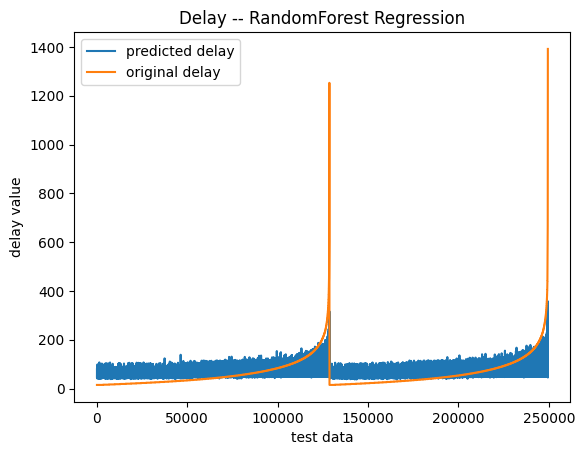

In [28]:
print("RandomForest Regression - Graph")
plot_graph("RandomForest Regression", predictions_rf )

In [29]:
#Printing the Execution Time
print("Time taken for Random Forest Regression : ", rf_speed ,"seconds")

Time taken for Random Forest Regression :  91.37276577949524 seconds
